In this notebook, I will explore some APIs to makesure those APIs are useful to our project.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Google Trends API: Pytrends

### rate limit

One user reports that 1,400 sequential requests of a 4 hours timeframe got them to the limit. (Replicated on 2 networks)
It has been tested, and 60 seconds of sleep between requests (successful or not) appears to be the correct amount once you reach the limit.

In [2]:
# link for this API:
#     https://pypi.org/project/pytrends/#API

# connect to Google
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz = 360) 
    # hl is the language setting
    # tz is the Timezone Offset

# potential ways to break the rate limitation
# pytrends = TrendReq(hl='en-US', tz=360, timeout=(10,25) \
#  ,proxies=['https://34.203.233.13:80',], retries=2,\
#  backoff_factor=0.1, requests_args={'verify':False})

### Visualization & find the city/state with greatest passion

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Interest in coffee & tea over time in the United States')

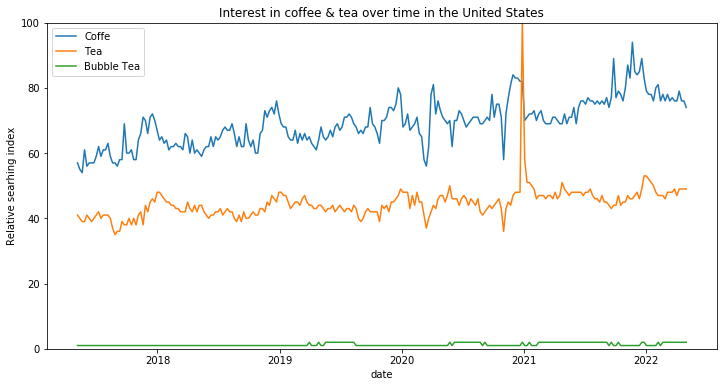

In [4]:
kw_list = ['Coffee','Tea','bubble tea']
fig, ax = plt.subplots(figsize=(12, 6))
# interest over time of United States.
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='US', gprop='')
result = pytrends.interest_over_time() 
# visualize trends
sns.lineplot(x=result.index, y=result["Coffee"]) 
sns.lineplot(x=result.index, y=result["Tea"]) 
sns.lineplot(x=result.index, y=result["bubble tea"])
ax.set(ylabel='Relative searhing index')
plt.legend(labels=["Coffe","Tea","Bubble Tea"])
plt.ylim(0, 100)
plt.title('Interest in coffee & tea over time in the United States')

In [23]:
kw_list = ['Coffee','Tea','bubble tea'] # maximum 5 words
topl = []
# find the top states
for i in range(len(kw_list)):
    pytrends.build_payload([kw_list[i]], cat=0, timeframe='today 5-y', geo='US', gprop='')
    InterestByRegion = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True, inc_geo_code=False)
    InterestByRegion = InterestByRegion.reset_index()
    InterestByRegion = InterestByRegion.sort_values(by=[kw_list[i]],ascending = False)
    topl.append([item for item in InterestByRegion.iloc[:5,:1]['geoName']])
    #print(topl[i])

intersec = list(set(topl[0]) & set(topl[1]) & set(topl[2])) 
rankdic = {}
for item in intersec:
    for i in range(len(topl)):
        if item not in rankdic:
            rankdic[item] = 0
        rankdic[item] += topl[i].index(item) 
rankdic = dict(sorted(rankdic.items(), key=lambda item: item[1]))
print(f'The state with highest interest is {list(rankdic.keys())[0]}.')

The state with highest interest is Oregon.


Text(0.5, 1.0, 'Interest over time of Oregon State')

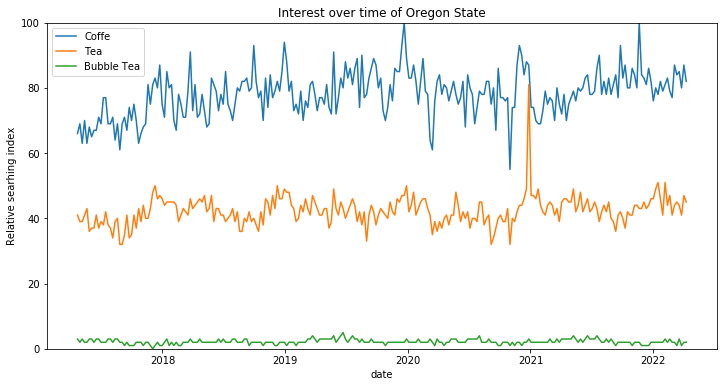

In [12]:
# interest over time of Oregon state.
fig, ax = plt.subplots(figsize=(12, 6))
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='US-OR', gprop='')
result = pytrends.interest_over_time() 
# visualize trends
sns.lineplot(x=result.index, y=result["Coffee"]) 
sns.lineplot(x=result.index, y=result["Tea"]) 
sns.lineplot(x=result.index, y=result["bubble tea"])
ax.set(ylabel='Relative searhing index')
plt.legend(labels=["Coffe","Tea","Bubble Tea"])
plt.ylim(0, 100)
plt.title('Interest over time of Oregon State')

In [22]:
# find top city
topcity = []
for j in range(len(kw_list)):
    pytrends.build_payload([kw_list[j]], cat=0, timeframe='today 5-y', geo='US-OR', gprop='')
    InterestByRegion = pytrends.interest_by_region(resolution='CITY', inc_low_vol=True, inc_geo_code=False)
    InterestByRegion = InterestByRegion.reset_index()
    InterestByRegion = InterestByRegion.sort_values(by=[kw_list[j]],ascending = False)
    topcity.append([item for item in InterestByRegion.iloc[:5,:1]['geoName']])
    #print(topcity[j])
intersec = list(set(topcity[0]) & set(topcity[1]) & set(topcity[2]))
rankdic = {}
for item in intersec:
    for i in range(len(topcity)):
        if item not in rankdic:
            rankdic[item] = 0
        rankdic[item] += topcity[i].index(item) 
rankdic = dict(sorted(rankdic.items(), key=lambda item: item[1]))
print(f'The city with highest interest is {list(rankdic.keys())[0]}.')

The city with highest interest is Portland OR.


In [54]:
# get all interest data for cities
kw_list = ['Coffee','Tea','bubble tea']
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
geos_list = []
for s in states:
    geos_list.append(f'US-{s}')

df_final_h=pd.DataFrame()
for state in geos_list:
    pytrends.build_payload(kw_list, cat=0, timeframe='all', geo=state, gprop='')
    InterestOverTime = pytrends.interest_over_time()
    InterestOverTime.rename(columns = {'Coffee':f'{state}_Coffee','Tea':f'{state}_Tea','bubble tea':f'{state}_bubbleTea'},inplace = True)
    df_tem = InterestOverTime.iloc[:, [0,1,2,3]]
    df_final_h = pd.concat([df_final_h, df_tem], axis=1)
df_final_h = df_final_h.reset_index()
df_final_v = df_final_h.T

In [55]:
df_final_h.to_csv('/Users/zhangjiawen/Desktop/STATS170A-B/170-personalized/google_trend/df_final_h.csv')
df_final_v.to_csv('/Users/zhangjiawen/Desktop/STATS170A-B/170-personalized/google_trend/df_final_v.csv')

## -----------------------------------------------------------------------------------------

In [56]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
print(len(states))

51


In [104]:
# import collections
# a = list(df_coffee['geoName'])
# print([item for item, count in collections.Counter(a).items() if count > 1])
pytrends.build_payload(['Coffee'], cat=0, timeframe='today 5-y', geo='US-WY', gprop='')
InterestByRegion = pytrends.interest_by_region(resolution='CITY', inc_low_vol=True, inc_geo_code=False)
InterestByRegion

,Coffee
geoName,
"Billings, MT",94
Casper-Riverton WY,83
Cheyenne WY-Scottsbluff NE,72
Denver CO,100
Idaho Falls-Pocatello ID,66
Rapid City SD,99
Salt Lake City UT,76


In [106]:
df_tea

,geoName,Tea
0,Phoenix AZ,91
1,Tucson (Sierra Vista) AZ,100
2,Yuma AZ-El Centro CA,83
3,Bend OR,82
4,Boise ID,73
5,Eugene OR,91
6,Medford-Klamath Falls OR,96
7,Portland OR,100
8,Yakima-Pasco-Richland-Kennewick WA,76
9,Bakersfield CA,75


In [113]:
#join three table together
dff = df_tea.merge(df_bubbletea,on='geoName',how='left')
final_df = df_coffee.merge(dff, on='geoName',how='left')
final_df = final_df.drop_duplicates(subset='geoName', keep='first', inplace=False)
final_df.to_csv('/Users/zhangjiawen/Desktop/STATS170A-B/170-personalized/google_trend/final_df_sample.csv')

# -----------------------------------------------------------------------------------------

### Some other functions

In [53]:
# search for real time trends
pytrends.trending_searches(pn='united_states').head()

,0
0,Dwayne Haskins
1,Scottie Scheffler
2,UFC 273
3,PSG
4,Ryan Garcia


In [57]:
# The top trends in past year?
pytrends.top_charts('2021', hl='en-US', tz=300, geo='GLOBAL')

,title,exploreQuery
0,Australia vs India,
1,India vs England,
2,IPL,
3,NBA,
4,Euro 2021,
5,Copa América,Copa America
6,India vs New Zealand,
7,T20 World Cup,
8,Squid Game,
9,DMX,


In [52]:
# suggestions words for searching
pytrends.suggestions(keyword = 'coffee')
    # return a list of dicts

[{'mid': '/m/02vqfm', 'title': 'Coffee', 'type': 'Drink'},
 {'mid': '/g/1q6j5bq4l', 'title': 'coffeemaker', 'type': 'Topic'},
 {'mid': '/m/07xyvk', 'title': 'Coffeemaker', 'type': 'Topic'},
 {'mid': '/m/020fb2', 'title': 'Cafe', 'type': 'Topic'},
 {'mid': '/m/05bzrs', 'title': 'Coffee bean', 'type': 'Topic'}]

In [55]:
pytrends.categories()

{'children': [{'children': [{'name': 'Celebrities & Entertainment News',
     'id': 184},
    {'children': [{'name': 'Animated Films', 'id': 1104},
      {'name': 'Anime & Manga', 'id': 317},
      {'name': 'Cartoons', 'id': 319},
      {'name': 'Comics', 'id': 318}],
     'name': 'Comics & Animation',
     'id': 316},
    {'children': [{'children': [{'name': 'Film & TV Awards', 'id': 1108},
        {'name': 'Film & TV Production', 'id': 1117}],
       'name': 'Film & TV Industry',
       'id': 1116},
      {'children': [{'name': 'Music Awards', 'id': 1113},
        {'name': 'Record Labels', 'id': 1114}],
       'name': 'Recording Industry',
       'id': 1115}],
     'name': 'Entertainment Industry',
     'id': 612},
    {'children': [{'name': 'Clubs & Nightlife', 'id': 188},
      {'name': 'Concerts & Music Festivals', 'id': 891},
      {'name': 'Film Festivals', 'id': 1086},
      {'name': 'Live Sporting Events', 'id': 1273},
      {'name': 'Movie Listings & Theater Showtimes', 'id':